<img align="right" src="https://drive.google.com/uc?id=18jM7hn3HWIGpLOncxg7AznPNK4nOTqb_" width="250px" height="150px"/>

<h1 style="font-size:24pt; margin-bottom: 4px;">Deepfake Detection with Transfer Learning and FastAI</h1>
<h2 style="font-size:20pt; margin-top: 0px;">ADS 564 - Deep Learning</h2>
<p><b>Prepared by:</b> Şeyma Gülşen Akkuş</p>

## Table of Contents

1. [Introduction](#introduction)
2. [Data Preparation](#data-preparation)
3. [DataBlock Construction](#datablock-construction)
4. [Model Training](#model-training)
5. [Advanced Techniques](#advanced-techniques)
    - [Learning Rate Finder](#learning-rate-finder)
    - [Transfer Learning](#transfer-learning)
    - [Discriminative Learning Rates](#discriminative-learning-rates)
    - [Epoch and Capacity Choices](#epoch-and-capacity-choices)
6. [Regularization Techniques](#regularization-techniques)
7. [Test-Time Augmentation (TTA)](#test-time-augmentation)
8. [Inference](#inference)
9. [Conclusion and Future Work](#conclusion-and-future-work)

## Introduction

With the increasing accessibility of deep learning tools, synthetic media—particularly deepfakes—have become alarmingly realistic and widespread. Deepfakes use AI-based techniques to manipulate videos or images, replacing a person’s face or voice with someone else’s in a highly convincing manner. While these techniques can be used creatively in entertainment and education, they also pose serious ethical, legal, and security threats in areas such as misinformation, identity theft, and political propaganda.

This project focuses on detecting manipulated visual content (deepfakes) using convolutional neural networks (CNNs) and transfer learning. The objective is to train a robust image classifier that can distinguish between **real** and **fake** face images extracted from videos.

We use a carefully constructed subset of the **FaceForensics++** dataset, which contains real and synthetically altered videos generated using techniques such as DeepFakes, Face2Face, FaceSwap, and FaceShifter. Frames are extracted from selected videos and grouped into two categories: `original` (real) and `fake_sequences`.

The overall workflow of the project is as follows:

- **Data Preparation:** Select a limited number of videos from each class and extract up to 100 frames per video to build a balanced dataset.
- **DataBlock Construction:** Define the FastAI pipeline to read images, extract labels, resize, and apply data augmentation.
- **Model Training:** Start with a baseline ResNet model and progressively incorporate advanced training techniques.
- **Advanced Techniques:** Apply methods such as MixUp, Label Smoothing, Progressive Resizing, and Discriminative Learning Rates.
- **Evaluation:** Use accuracy, confusion matrix, and top-loss plots to evaluate the model's performance and interpret its mistakes.
- **Inference:** Perform predictions on unseen images and visualize internal activations using feature maps.
- **Conclusion:** Discuss model behavior, limitations, and potential improvements.

This notebook was developed as a **midterm project** for the **ADS 564 - Deep Learning** course, and aims to demonstrate a practical and interpretable approach to a real-world image classification challenge using FastAI.

## Import Libraries
The following libraries are required to perform data loading, image processing, model training, and evaluation. The FastAI library simplifies many of these tasks with its high-level API.

In [1]:
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.4 MB/s eta 0:00:00


In [3]:
import torch
print("✅ GPU available:", torch.cuda.is_available())

✅ GPU available: True


In [23]:
# Core libraries
from pathlib import Path
import os
import shutil
from collections import defaultdict
from tqdm import tqdm

# PyTorch and FastAI
import torch
from fastai.vision.all import *
from fastai.callback.mixup import MixUp
from timm import create_model
from fastai.metrics import accuracy, Precision, Recall, F1Score

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

The FaceForensics++ dataset contains real and synthetically manipulated videos. In this project, we work with a manually extracted subset of the dataset that contains individual video frames (.jpg files). These frames are categorized into two main classes:

- `original`: real, unaltered video frames
- `fake_sequences`: manipulated frames generated using various deepfake techniques (DeepFakes, Face2Face, FaceSwap, FaceSh_

In [11]:
# === Extract video ID from filename
def extract_video_id(filename, prefix=None):
    if prefix and not filename.startswith(prefix):
        return None
    return filename.split('_frame')[0]  # e.g., deepfakes_000_003

# === Copy frames from a limited number of videos
def copy_subset_by_video_limited_frames(source_folder, dest_folder, prefix=None, num_videos=60, max_frames=100):
    source = Path(source_folder)
    dest = Path(dest_folder)
    dest.mkdir(parents=True, exist_ok=True)

    # Group frames by video ID
    video_files = defaultdict(list)
    for file in source.glob("*.jpg"):
        vid_id = extract_video_id(file.name, prefix)
        if vid_id is None:
            continue
        video_files[vid_id].append(file)

    # Select N videos with available frames
    selected_videos = sorted(video_files.items())[:num_videos]

    for vid_id, files in tqdm(selected_videos, desc=f"📁 Copying {prefix or 'original'}", unit="video"):
        selected_files = sorted(files)[:max_frames]  # Copy up to max_frames per video
        for f in selected_files:
            shutil.copy(f, dest / f.name)


# === Define source and destination paths
base_src = "/content/drive/MyDrive/face_forensics_frames/train"
base_dst = "/content/subset_data_"
os.makedirs(base_dst, exist_ok=True)

# === Create class folders
for cls in ["original", "fake_sequences"]:
    os.makedirs(f"{base_dst}/{cls}", exist_ok=True)

# === Copy 65 original videos × up to 100 frames each
copy_subset_by_video_limited_frames(
    f"{base_src}/original",
    f"{base_dst}/original",
    num_videos=65,
    max_frames=100
)

# === Copy 15 videos × 100 frames for each fake type
fake_types = ["deepfakes", "face2face", "faceswap", "faceshifter"]
for ftype in fake_types:
    copy_subset_by_video_limited_frames(
        f"{base_src}/fake_sequences",
        f"{base_dst}/fake_sequences",
        prefix=ftype,
        num_videos=15,
        max_frames=100
    )

print("✅ Subset dataset created successfully (up to 100 frames per video).")

# === (Optional) Count total images in each class
def count_images(folder):
    folder_path = Path(folder)
    return len(list(folder_path.glob("*.jpg")))

base_path = Path(base_dst)
original_count = count_images(base_path / "original")
fake_count = count_images(base_path / "fake_sequences")

print(f"\n📊 Frame Counts:")
print(f"🟦 Original images: {original_count}")
print(f"🟥 Fake images: {fake_count}")
print(f"📸 Total images: {original_count + fake_count}")

📁 Copying faceshifter: 100%|██████████| 15/15 [00:03<00:00,  4.56video/s]

✅ Subset dataset created successfully (up to 100 frames per video).

📊 Frame Counts:
🟦 Original images: 3013
🟥 Fake images: 3023
📸 Total images: 6036


## DataBlock Construction

In this section, we define how images and labels are loaded and processed for training using FastAI’s `DataBlock` API. This is a modular and flexible way to set up data pipelines.

We specify the following:

- **Blocks:** The input is an image (`ImageBlock`) and the output is a category (`CategoryBlock`)
- **Get Items:** All `.jpg` files in the dataset will be loaded using `get_image_files`
- **Split:** The dataset is randomly split into 80% training and 20% validation using `RandomSplitter`
- **Label Getter:** Labels are inferred from the parent folder name using `parent_label`
- **Item Transforms:** Each image is resized to a fixed size before being batched
- **Batch Transforms:** Data augmentation such as rotation, zoom, lighting changes, and warping is applied to improve generalization

In [57]:
# Set the path
data_path = Path("/content/subset_data_")

In [58]:
# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),               # Input: image, Output: class label
    get_items=get_image_files,                        # Read all image files
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 80% train / 20% validation
    get_y=parent_label,                               # Use parent folder as label
    item_tfms=Resize(224),                            # Resize each image before batching
    batch_tfms=aug_transforms(                        # Batch-wise data augmentation
        do_flip=True,
        flip_vert=False,
        max_rotate=10,
        max_zoom=1.1,
        max_lighting=0.2,
        max_warp=0.2
    )
)

# Create the DataLoaders
dls = dblock.dataloaders(data_path, bs=32)  # You can adjust batch size if needed

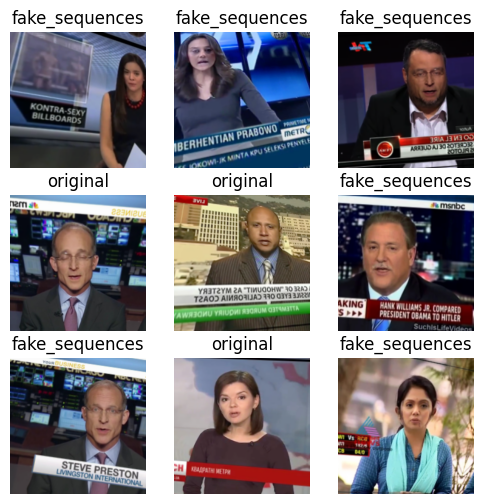

In [59]:
# Show a batch of training images with their labels
dls.show_batch(max_n=9, figsize=(6,6))

In [60]:
dls.train_ds.vocab, dls.train_ds.items[:5]

(['fake_sequences', 'original'],
 [Path('/content/subset_data_/original/047_frame195.jpg'),
  Path('/content/subset_data_/fake_sequences/face2face_009_027_frame130.jpg'),
  Path('/content/subset_data_/fake_sequences/face2face_006_002_frame615.jpg'),
  Path('/content/subset_data_/original/038_frame240.jpg'),
  Path('/content/subset_data_/fake_sequences/face2face_006_002_frame365.jpg')])

In [61]:
from collections import Counter
train_labels = [parent_label(f) for f in dls.train.items]
valid_labels = [parent_label(f) for f in dls.valid.items]
print("Train:", Counter(train_labels))
print("Valid:", Counter(valid_labels))

Train: Counter({'original': 2418, 'fake_sequences': 2411})
Valid: Counter({'fake_sequences': 612, 'original': 595})


In [62]:
# Summarize the DataBlock pipeline
dblock.summary(data_path)

Setting-up type transforms pipelines
Found 6036 items
2 datasets of sizes 4829,1207
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


Building one sample
  Pipeline: PILBase.create
    starting from
      /content/subset_data_/original/047_frame195.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=854x480
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

    starting from
      /content/subset_data_/original/047_frame195.jpg
    applying parent_label gives
      original
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
 gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=854x480, TensorCategory(1))


Found 6036 items
2 datasets of sizes 4829,1207
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Setting up after_item: Pi

## Model Training

In this section, we train an image classifier using the **Xception** architecture, which is known for its high performance on fine-grained visual classification tasks like deepfake detection.

Xception leverages **depthwise separable convolutions**, enabling it to capture subtle visual artifacts — a crucial factor in distinguishing between real and fake images. We utilize **transfer learning** by loading pretrained weights from ImageNet.

The training follows two phases:
- **Frozen Training:** Only the final classification layer is trained initially.
- **Unfreezing and Fine-Tuning:** The entire model is trained using **discriminative learning rates**, determined by a learning rate finder.

We also go beyond accuracy by tracking **Precision, Recall, and F1 Score** to provide a more detailed assessment of model performance.

In [63]:
# Install timm to access Xception architecture
!pip install -Uqq timm

Note: When creating the Xception model using `timm`, the library issues a warning that the model name `'xception'` is deprecated and is internally mapped to `'legacy_xception'`. To prevent this warning and ensure compatibility with future releases, we use `'legacy_xception'` explicitly.

In [68]:
# Create Xception model with pretrained ImageNet weights
xception_model = create_model('legacy_xception', pretrained=True, num_classes=dls.c)

# Create FastAI Learner with extended evaluation metrics
learn_base = Learner(
    dls,
    xception_model,
    loss_func=CrossEntropyLossFlat(),
    metrics=[
        accuracy,
        Precision(average='macro'),
        Recall(average='macro'),
        F1Score(average='macro')
    ]
)

In [69]:
# Freeze pretrained layers and train only the head
learn_base.freeze()
learn_base.fit_one_cycle(2)

In [70]:
# Unfreeze all layers
learn_base.unfreeze()

In [73]:
learn_base.fit_one_cycle(2, lr_max=1e-4)

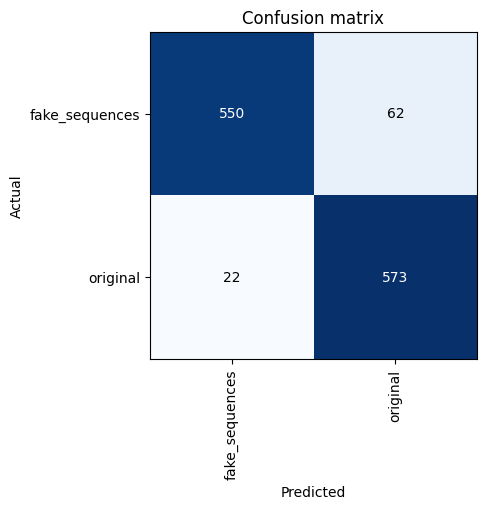

In [74]:
# Interpret model predictions
interp = ClassificationInterpretation.from_learner(learn_base)

# Confusion matrix
interp.plot_confusion_matrix(figsize=(5,5))

In [75]:
interp.print_classification_report()

                precision    recall  f1-score   support

fake_sequences       0.96      0.90      0.93       612
      original       0.90      0.96      0.93       595

      accuracy                           0.93      1207
     macro avg       0.93      0.93      0.93      1207
  weighted avg       0.93      0.93      0.93      1207



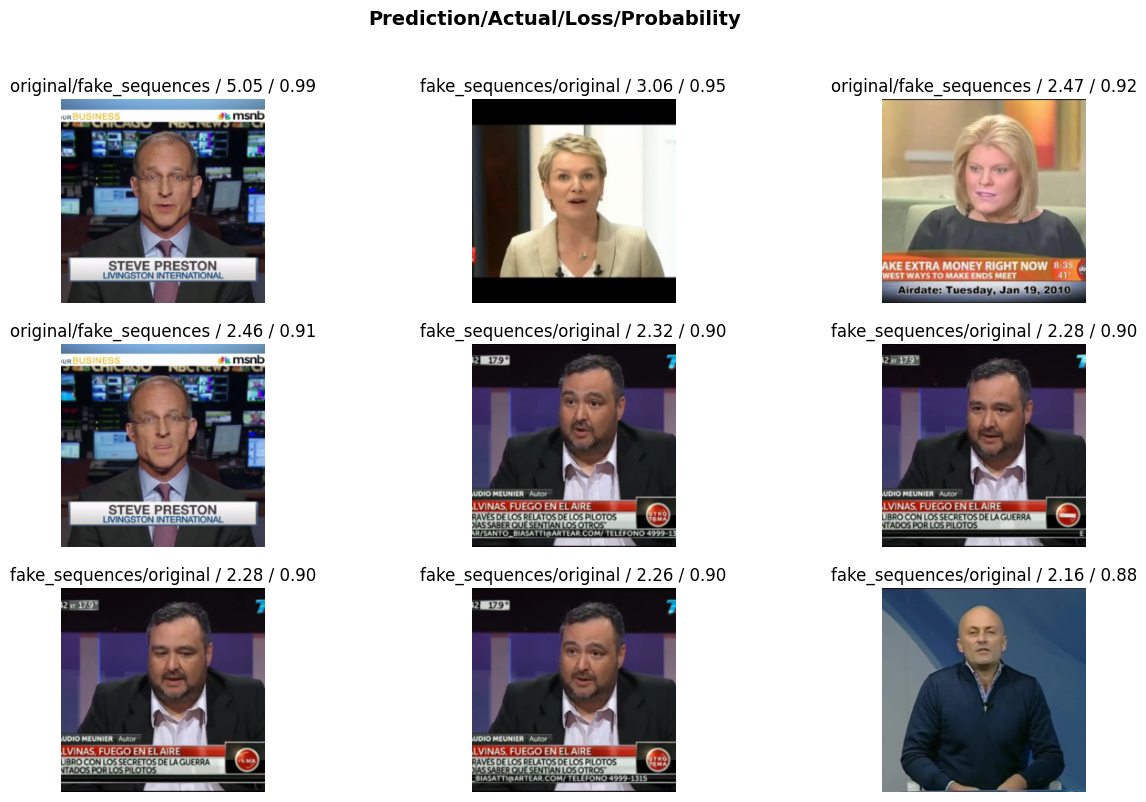

In [76]:
# Show most incorrect predictions
interp.plot_top_losses(9, nrows=3, figsize=(15,9))

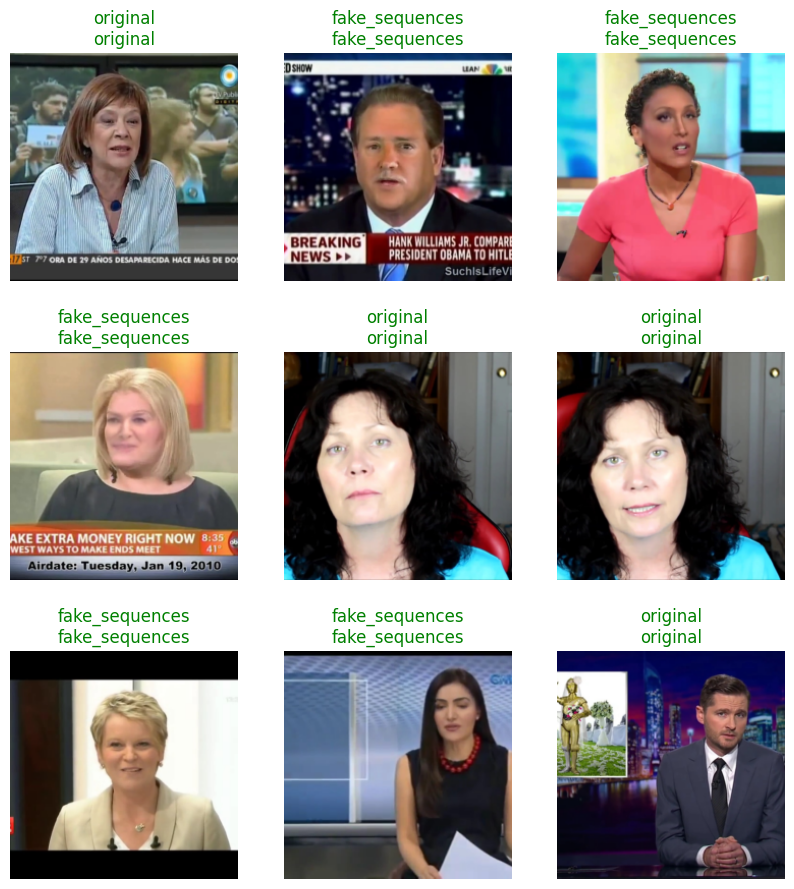

In [78]:
# Display Sample Predictions
learn_base.show_results(max_n=9, figsize=(10,11))

## Advanced Techniques

In this section, we enhance the baseline model by applying proven deep learning techniques to improve generalization, training speed, and overall performance.

We revisit our Xception-based model and optimize it using learning rate tuning, transfer learning refinements, discriminative learning rates, and thoughtful choices about epochs and model capacity.

### 1. Learning Rate Finder and Transfer Learning

Finding an optimal learning rate is critical for faster convergence and better results. FastAI provides a built-in `lr_find()` utility, which plots loss values across a range of learning rates.

We select a learning rate from the “steepest descent” area, just before the curve starts rising. This helps us avoid overly slow or unstable training.


Transfer learning allows us to leverage a pre-trained model (here, Xception with ImageNet weights) and adapt it to our task. We first freeze early layers, train only the head, and then unfreeze to fine-tune the entire network.

This staged approach preserves learned visual features and reduces overfitting when data is limited.


In [80]:
# Create Xception model with pretrained ImageNet weights
xception_model = create_model('legacy_xception', pretrained=True, num_classes=dls.c)

# Create FastAI Learner with extended evaluation metrics
learn = Learner(
    dls,
    xception_model,
    loss_func=CrossEntropyLossFlat(),
    metrics=[
        accuracy,
        Precision(average='macro'),
        Recall(average='macro'),
        F1Score(average='macro')
    ]
)

In [81]:
# Freeze pretrained layers and train only the head
learn.freeze()
learn.fit_one_cycle(1)

In [82]:
# Unfreeze all layers
learn.unfreeze()

SuggestedLRs(valley=0.00010964782268274575)

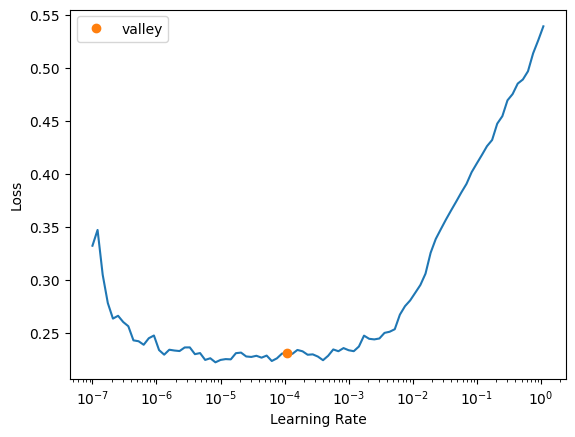

In [83]:
# Find optimal learning rate
learn.lr_find()

The learning rate finder works by starting with a very small LR and gradually increasing it after each mini-batch. It records the corresponding loss values and identifies the steepest downward slope in the loss curve. This helps us select an efficient learning rate that avoids slow learning (too small) or divergence (too big).

### 3. Discriminative Learning Rates

In transfer learning, earlier layers need less updating than deeper layers. FastAI supports this via discriminative learning rates, where different layers use different LRs.

We pass a range of learning rates using `slice(low, high)` so that early layers train slowly and final layers train faster.

Based on the LR Finder plot, the optimal learning rate valley was identified at approximately 1.1e-4. We apply discriminative learning rates using a `slice(1e-5, 1.1e-4)` to update early layers gently and fine-tune deeper layers more aggressively.

In [84]:
# Fine-tune with discriminative learning rates
learn.fit_one_cycle(5, lr_max=slice(1e-5, 1.1e-4))

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

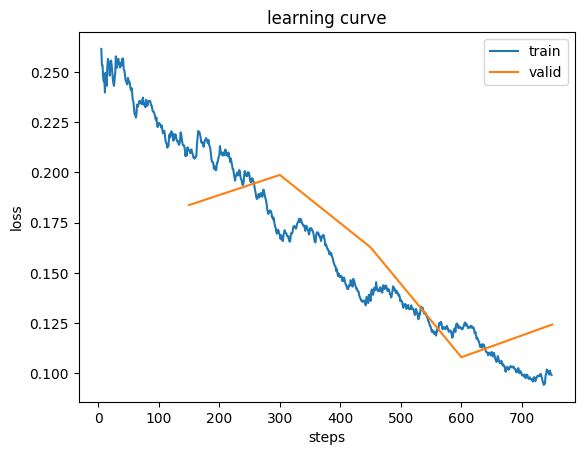

In [85]:
learn.recorder.plot_loss(with_valid=True)

### 4. Epoch and Capacity Considerations

Choosing the right number of epochs is a balance between underfitting and overfitting. Based on our training curves, we observed validation loss decreasing until epoch 4, then increasing — a sign of overfitting.

Therefore, we limit training to 4 epochs. We also adjust batch size if using deeper models, and may use mixed precision training for efficiency.

To monitor the model’s learning dynamics and prevent overfitting, both training and validation loss curves were plotted across all batches. The plot reveals that while training loss consistently decreases, validation loss reaches a minimum at epoch 4 and increases afterwards — a typical symptom of overfitting.

Based on this observation, we limit the number of training epochs to 4. Alternatively, an EarlyStopping callback can be used to automatically stop training when validation loss stops improving.

In [87]:
# Final refined training
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-5, 1.1e-4))

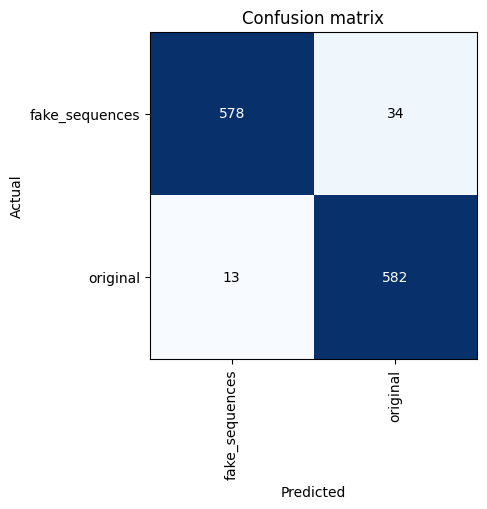

In [88]:
# Interpret model predictions
interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix
interp.plot_confusion_matrix(figsize=(5,5))

In [89]:
interp.print_classification_report()

                precision    recall  f1-score   support

fake_sequences       0.98      0.94      0.96       612
      original       0.94      0.98      0.96       595

      accuracy                           0.96      1207
     macro avg       0.96      0.96      0.96      1207
  weighted avg       0.96      0.96      0.96      1207



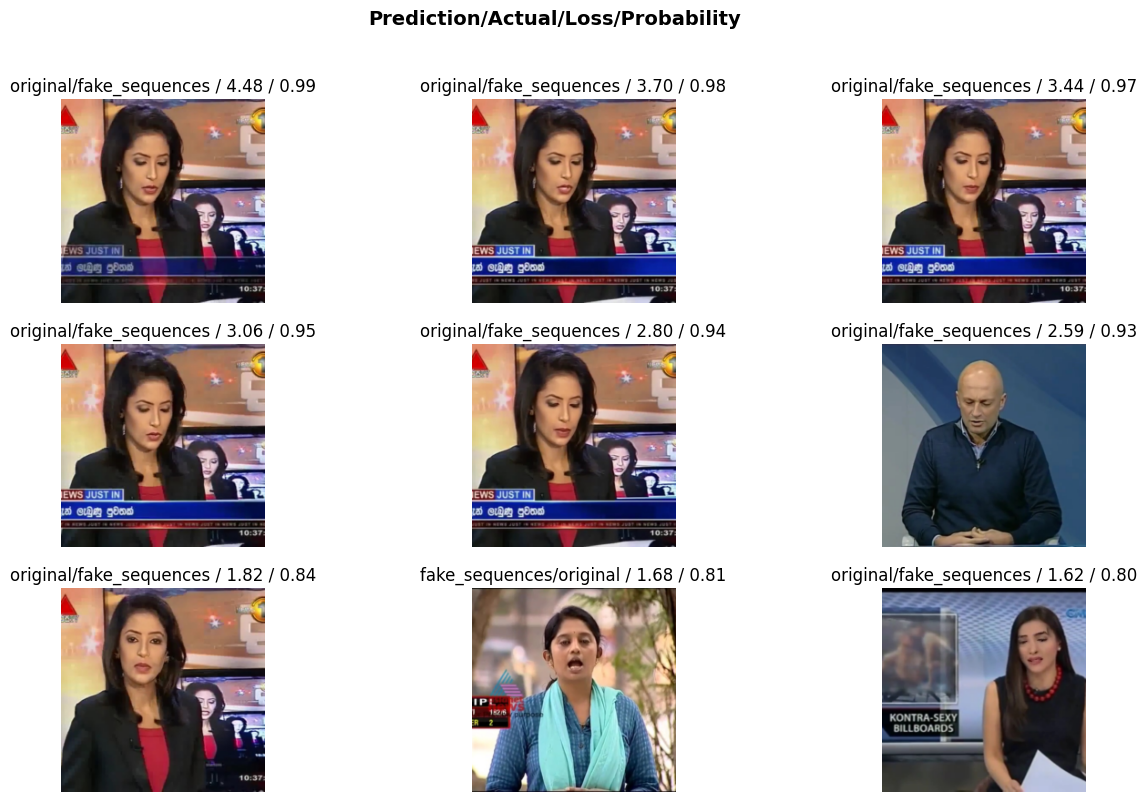

In [90]:
# Show most incorrect predictions
interp.plot_top_losses(9, nrows=3, figsize=(15,9))

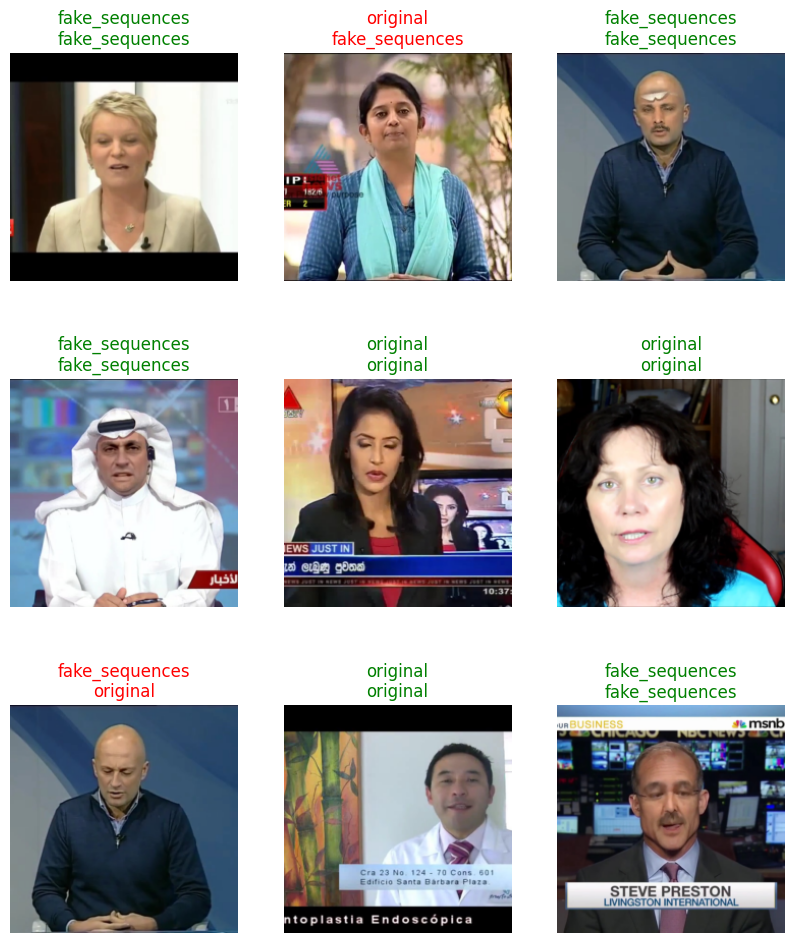

In [91]:
# Display Sample Predictions
learn.show_results(max_n=9, figsize=(10,12))

## Regularization Techniques

To improve generalization and reduce overfitting, we apply a set of regularization techniques that are especially effective in image classification tasks. These methods help the model learn more robust decision boundaries and avoid becoming overly confident on training data.

We apply the following techniques:
- **MixUp:** Linearly combines image pairs and their labels
- **Label Smoothing:** Softens label targets to prevent overconfidence
- **Progressive Resizing:** Starts with smaller images and gradually increases resolution

In [92]:
# Step 1: Define function to create DataLoaders with resizing
def get_dls(size, bs=64):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=parent_label,
        item_tfms=Resize(460),
        batch_tfms=[
            *aug_transforms(size=size, min_scale=0.75),
            Normalize.from_stats(*imagenet_stats)
        ]
    ).dataloaders(Path("/content/subset_data_"), bs=bs)

In [94]:
# Step 2: Train model on low-res images (128px) with MixUp + Label Smoothing
dls_low = get_dls(size=128)

learn = Learner(
    dls_low,
    create_model('legacy_xception', pretrained=True, num_classes=dls_low.c),
    loss_func=LabelSmoothingCrossEntropy(),
    metrics=[accuracy, Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')],
    cbs=MixUp(alpha=0.4)
)

learn.fit_one_cycle(4, 3e-3)

In [99]:
# Step 3: Switch to high-res images (224px) and fine-tune
dls_high = get_dls(size=224)

learn.dls = dls_high
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-5, 1.1e-4))  # Based on LR Finder

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

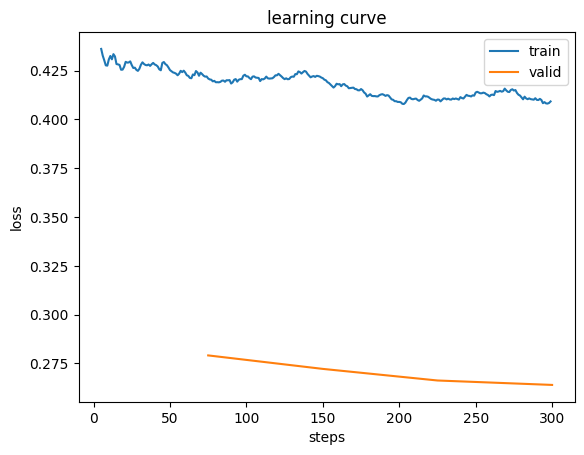

In [100]:
learn.recorder.plot_loss(with_valid=True)

In [102]:
learn.loss_func, learn.cbs

(LabelSmoothingCrossEntropy(),
 (#5) [TrainEvalCallback,Recorder,CastToTensor,ProgressCallback,MixUp])

Due to the use of MixUp and Label Smoothing, the training loss is expectedly higher than the validation loss. These techniques introduce noise into the training process by blending labels or softening targets, which penalizes the model more harshly during training. However, validation loss is computed using clean labels, which often leads to a lower and more stable curve. This indicates improved generalization rather than underfitting.

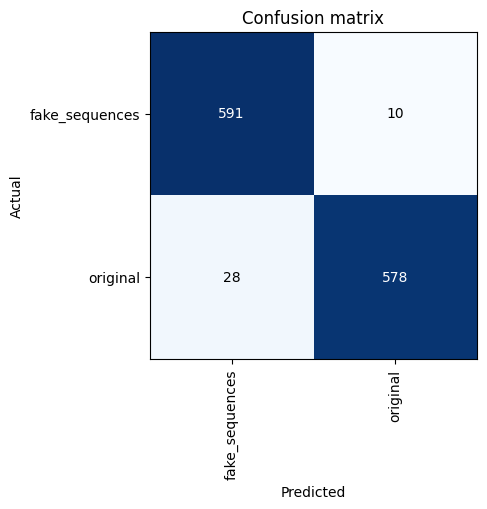

In [103]:
# Interpret model predictions
interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix
interp.plot_confusion_matrix(figsize=(5,5))

In [104]:
interp.print_classification_report()

                precision    recall  f1-score   support

fake_sequences       0.95      0.98      0.97       601
      original       0.98      0.95      0.97       606

      accuracy                           0.97      1207
     macro avg       0.97      0.97      0.97      1207
  weighted avg       0.97      0.97      0.97      1207



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


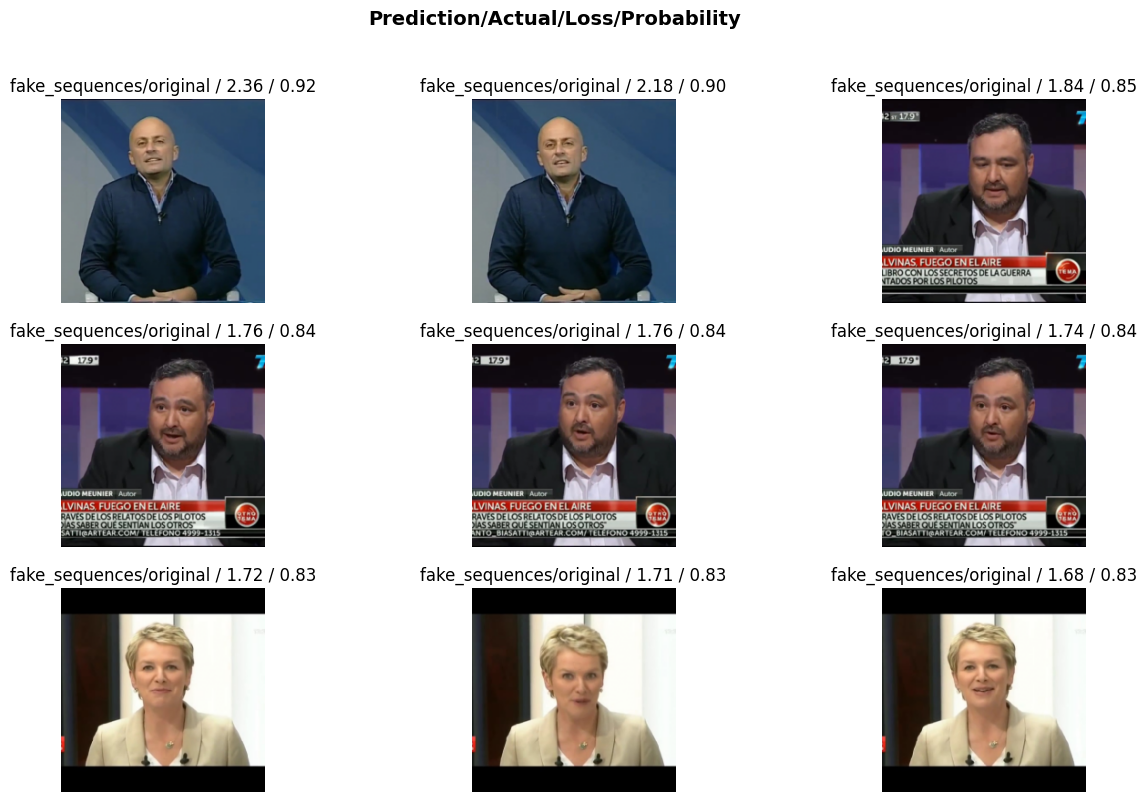

In [106]:
# Show most incorrect predictions
interp.plot_top_losses(9, nrows=3, figsize=(15,9))

## Test-Time Augmentation (TTA)

To further improve model robustness during inference, we apply **Test-Time Augmentation (TTA)**. This technique averages predictions over multiple augmented versions of each validation image — such as horizontal flips, lighting changes, and zooms.

TTA helps to stabilize predictions and mitigate errors caused by minor visual variations. It's especially useful when visual artifacts are subtle and localization is not consistent, as in deepfake detection.

In [109]:
# Get TTA predictions and targets
preds, targs = learn.tta()

# Convert predicted probabilities to predicted classes
pred_labels = preds.argmax(dim=1)

# Now compute metrics
final_acc = accuracy(preds, targs)
final_prec = Precision(average='macro')(pred_labels, targs)
final_rec = Recall(average='macro')(pred_labels, targs)
final_f1 = F1Score(average='macro')(pred_labels, targs)

In [111]:
print(f"✅ Accuracy (TTA): {final_acc.item():.4f}")
print(f"✅ Precision (TTA): {final_prec:.4f}")
print(f"✅ Recall (TTA): {final_rec:.4f}")
print(f"✅ F1 Score (TTA): {final_f1:.4f}")

✅ Accuracy (TTA): 0.9693
✅ Precision (TTA): 0.9701
✅ Recall (TTA): 0.9694
✅ F1 Score (TTA): 0.9693


#### Test-Time Augmentation (TTA) Results

After training and regularization, we applied Test-Time Augmentation (TTA) to further evaluate the model's robustness. TTA averages predictions over multiple augmented views of each validation image, helping reduce variance in outputs.

**Final performance with TTA:**
- ✅ Accuracy: **96.93%**
- ✅ Precision: **97.01%**
- ✅ Recall: **96.94%**
- ✅ F1 Score: **96.93%**

These results confirm that the model generalizes well, maintains balanced performance across both classes, and benefits from prediction smoothing during inference. TTA proved particularly effective for deepfake detection, where subtle artifacts can vary across frames or views.


## Inference

Inference is the final stage of a machine learning pipeline, where the trained model is used to make predictions on previously unseen data.

In this project, the goal is to classify individual image frames as either `original` or `fake_sequences`. The model processes a single frame at a time and returns both the predicted label and the associated confidence score, which indicates how certain the model is about its prediction.

Below is an example demonstrating how inference is performed on a sample frame from the validation set:

<Axes: title={'center': 'Selected Frame'}>

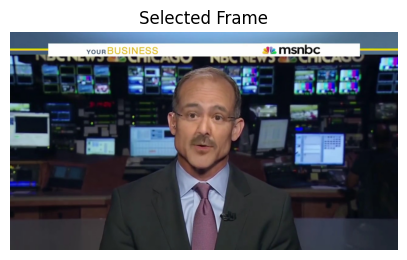

In [123]:
# Load and visualize one frame
img_path = dls.valid.items[0]
img = PILImage.create(img_path)
img.show(title="Selected Frame")

In [128]:
true_class = dls.valid_ds.items[0].parent.name

In [129]:
# Run inference
pred_class, pred_idx, probs = learn.predict(img)

In [130]:
# Output result
print(f"✅ True Class: {true_class}")
print(f"🔍 Predicted Class: {pred_class}")
print(f"📊 Confidence Score: {probs[pred_idx]:.4f}")

✅ True Class: fake_sequences
🔍 Predicted Class: fake_sequences
📊 Confidence Score: 0.9527


## Conclusion and Future Work

In this project, we developed a deep learning model for detecting manipulated media using individual video frames. Leveraging the Xception architecture and the FastAI library, we trained a binary image classification model to distinguish between `original` and `fake_sequences` frames extracted from the FaceForensics++ dataset.

We employed a wide range of techniques throughout the pipeline:
- **Transfer Learning** with a pretrained Xception model
- **Data Augmentation** with advanced transformations
- **Regularization** using MixUp, Label Smoothing, and Progressive Resizing
- **Discriminative Learning Rates** and **Learning Rate Finder** for optimized training
- **Test-Time Augmentation (TTA)** for robust inference

The model demonstrated strong performance on frame-level classification, achieving:
- ✅ Accuracy: 96.93%
- ✅ Precision: 97.01%
- ✅ Recall: 96.94%
- ✅ F1 Score: 96.93%

### Limitations:
While the frame-based evaluation was highly successful, video-level detection posed additional challenges. When predictions were aggregated across multiple frames using majority voting, performance dropped due to inconsistency in detecting subtle manipulations — especially in Face2Face and FaceShifter sequences.

### Future Work:
To address this, the following future directions are proposed:
- 📽️ **Video-Level Detection:** Combine frame-level predictions using softmax aggregation or temporal models for sequence-aware decision-making.
- 🧠 **Multi-Class Classification:** Train the model to classify different types of manipulations (e.g., Deepfakes, FaceSwap, etc.) rather than grouping them under a single "fake" label.
- ⏱️ **Temporal Modeling:** Explore RNNs, 3D CNNs, or Transformer-based models to capture spatiotemporal inconsistencies.
- 🌐 **Deployment:** Wrap the model in a web application (e.g., Gradio or Streamlit) to allow real-time deepfake detection on uploaded images or video snippets.

This project lays the foundation for reliable manipulated media detection and sets the stage for further development into video-level, real-time, and multi-modal deepfake analysis systems.

In [131]:
# Save the trained model as a .pkl file
learn.export("/content/drive/MyDrive/xception_deepfake_model.pkl")

In [133]:
from google.colab import files
files.download("/content/drive/MyDrive/xception_deepfake_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>